In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List
import sys

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None)

train_data[2]

(tensor([[[183, 157, 130,  ..., 255, 255, 255],
          [145, 144, 135,  ..., 255, 255, 255],
          [131, 144, 138,  ..., 255, 255, 255],
          ...,
          [104, 114, 129,  ..., 255, 255, 255],
          [105, 117, 134,  ..., 255, 255, 255],
          [105, 119, 138,  ..., 255, 255, 255]],
 
         [[171, 144, 116,  ..., 255, 255, 255],
          [133, 131, 121,  ..., 255, 255, 255],
          [119, 131, 124,  ..., 255, 255, 255],
          ...,
          [ 70,  81,  97,  ..., 255, 255, 255],
          [ 71,  84, 102,  ..., 255, 255, 255],
          [ 71,  86, 106,  ..., 255, 255, 255]],
 
         [[131, 109,  90,  ..., 255, 255, 255],
          [ 93,  96,  94,  ..., 255, 255, 255],
          [ 79,  96,  97,  ..., 255, 255, 255],
          ...,
          [ 68,  76,  86,  ..., 255, 255, 255],
          [ 69,  79,  91,  ..., 255, 255, 255],
          [ 69,  81,  95,  ..., 255, 255, 255]]], dtype=torch.uint8),
 {'image_id': tensor([2]),
  'labels': tensor([1]),
  'boxes': 

(<Figure size 512x512 with 1 Axes>, <Axes: >)

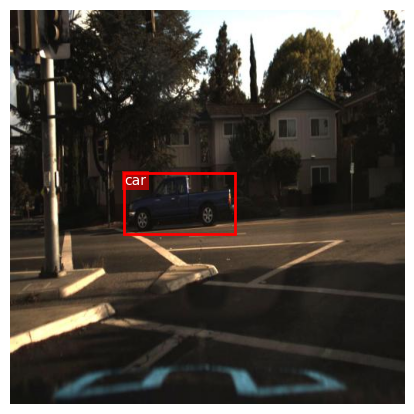

In [3]:
train_data.show_with_box(index=0, color='r', label=True)

In [15]:
# Create transform (no data augmentation)
data_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
])

In [16]:
data_transform.transforms

[Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True),
 RandomHorizontalFlip(p=0.5),
 Compose(
       ToImage()
       ToDtype(scale=True)
 )]

In [2]:
# 1. Load and transform data
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=False),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=transforms)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=transforms)

# 2. Turn data into DataLoaders
# Setup batch size and number of workers 
BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
#print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     #num_workers=NUM_WORKERS,
                                     )

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    #num_workers=NUM_WORKERS,
                                    )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16a6994b850>,
 <torch.utils.data.dataloader.DataLoader at 0x16a6994b880>)

In [7]:
train_data[0]

(tensor([[[ 50,  37,  28,  ..., 255, 245, 225],
          [ 33,  24,  19,  ..., 251, 234, 204],
          [ 23,  18,  17,  ..., 236, 205, 171],
          ...,
          [ 21,  21,  21,  ...,  98,  98,  97],
          [ 26,  26,  26,  ...,  97,  97,  96],
          [ 31,  30,  30,  ...,  97,  96,  95]],
 
         [[ 52,  39,  28,  ..., 255, 244, 222],
          [ 35,  26,  20,  ..., 251, 231, 201],
          [ 25,  20,  17,  ..., 234, 202, 168],
          ...,
          [ 17,  17,  17,  ...,  78,  78,  78],
          [ 22,  22,  22,  ...,  79,  79,  79],
          [ 27,  26,  26,  ...,  80,  80,  79]],
 
         [[ 47,  34,  24,  ..., 250, 238, 215],
          [ 30,  21,  15,  ..., 246, 225, 194],
          [ 20,  15,  13,  ..., 228, 195, 161],
          ...,
          [ 14,  14,  14,  ...,  58,  58,  58],
          [ 19,  19,  19,  ...,  60,  61,  62],
          [ 24,  23,  23,  ...,  62,  62,  63]]], dtype=torch.uint8),
 {'image_id': tensor([0]),
  'labels': tensor([1]),
  'boxes': 

In [25]:
torch.manual_seed(42)
testing = train_data[0]

In [34]:
testing[0].shape[-2]

224

In [27]:
testing[1]['boxes']

BoundingBoxes([[ 36.1667,  15.1864, 120.1667,  75.1729]], format=BoundingBoxFormat.XYXY, canvas_size=(224, 224))

In [32]:
(testing[1]['boxes'][:,2] - testing[1]['boxes'][:,0]).clamp(0, 80)

tensor([80.])

In [17]:
train_data[2][1]['boxes']

BoundingBoxes([[216.3090,   0.0000, 224.0000,  45.3034]], format=BoundingBoxFormat.XYXY, canvas_size=(224, 224))

(<Figure size 224x224 with 1 Axes>, <Axes: >)

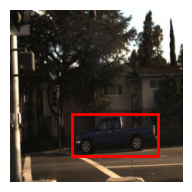

In [5]:
train_data.show_with_box(index=0, color='r', label=False)